In [1]:
import os
import gc
import sys

import random
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm.notebook import *
import matplotlib.pyplot as plt

import warnings
tqdm_notebook().pandas()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)
warnings.simplefilter("ignore")

0it [00:00, ?it/s]

In [2]:
train_data_path  = "/kaggle/input/datachallenge/train_set.csv"
test_data_path  = "/kaggle/input/datachallenge/test_set.csv"

In [3]:
df_trains = pd.read_csv(train_data_path)
df_tests = pd.read_csv(test_data_path)

In [4]:
drop_col = ["Vanne_position_1","Vanne_position_2"]
df_train = df_trains.drop(drop_col, axis= 1)
df_test  = df_tests.drop(drop_col, axis= 1)

In [5]:
df_train["scope"] = "train"
df_test["scope"] = "test"
df = pd.concat([df_train,df_test],axis=0)

In [6]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
df["Wind_turbine_name_enc"] = enc.fit_transform(df["Wind_turbine_name"])

In [7]:
from numba import jit, prange
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_union
from sklearn.impute import MissingIndicator

@jit
def knn_imputer(df, columns, n_neig=4):
    imputer = KNNImputer(n_neighbors=n_neig)
    pipeline = make_union(KNNImputer(n_neighbors=n_neig),
                     MissingIndicator())

    df_filled = pipeline.fit_transform(df[[columns]])
    return df_filled


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

In [9]:
@jit
def fill_na(df, columns):
    for col in tqdm(columns):
        df[col] =  pd.to_numeric(df[col].values, errors='coerce').astype('float32')
        scaler = StandardScaler()
        #df[col] = scaler.fit_transform(df[col].fillna(df[col].median()))
        df[col] = scaler.fit_transform(knn_imputer(df, col))
    return df

col_fill_na = ['Pitch_angle','Hub_temperature', 'Generator_converter_speed', 'Generator_temp_1',
               'Generator_temp_2', 'Nacelle_angle','Wind_direction', 'Outdoor_temp', 'Outdoor_temp_min','Outdoor_temp_min',
               'Outdoor_temp_max','Grid_frequency','Grid_voltage','Rotor_temp','wind_direction_corrected']
df_fill = fill_na(df, col_fill_na)

  0%|          | 0/15 [00:00<?, ?it/s]

In [10]:
df_fill

,Wind_turbine_name,Pitch_angle,Hub_temperature,Generator_converter_speed,Power,Generator_temp_1,Generator_temp_2,Nacelle_angle,Nacelle_temperature,Wind_direction,Outdoor_temp,Outdoor_temp_min,Outdoor_temp_max,Grid_frequency,Grid_voltage,Rotor_temp,wind_direction_corrected,date,scope,Wind_turbine_name_enc
0,R80711,-0.543596,-1.077654,-0.984032,1177.314967,-0.097150,0.382179,-0.140868,17.480000,-0.106140,-0.844340,-0.841079,-0.843493,0.013924,1.803602,0.242211,0.117047,2012-12-31 23:00:00+01:00,train,0
1,R80711,-0.543784,-1.118866,-0.967054,1200.676667,-0.438457,0.250170,-0.042433,17.075000,-0.089661,-0.811980,-0.815182,-0.826500,0.057049,1.781599,0.203957,0.135241,2013-01-01 00:00:00+01:00,train,0
2,R80711,-0.543784,-1.154994,-0.769609,1092.826665,-0.403630,0.303675,-0.042433,17.175000,-0.006354,-0.798694,-0.795759,-0.803134,0.066637,2.041837,0.185767,0.227222,2013-01-01 01:00:00+01:00,train,0
3,R80711,-0.542908,-1.167840,-0.731682,1080.954980,-0.037508,0.433814,-0.042433,16.761666,-0.023346,-0.871770,-0.871292,-0.868982,0.057060,1.014194,0.203423,0.208461,2013-01-01 02:00:00+01:00,train,0
4,R80711,-0.533018,-1.128768,-0.824860,1351.328317,-0.507241,0.184517,-0.064324,14.630000,-0.118133,-0.958776,-0.955456,-0.966692,0.047471,1.450734,0.134638,0.103805,2013-01-01 03:00:00+01:00,train,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52727,R80790,0.206735,-0.860886,2.265808,NaN,0.581982,0.274002,-1.499495,27.841667,-1.517630,-0.809195,-0.813024,-0.805258,0.057060,0.446378,-0.336403,-0.057217,2018-1-12T19:00+01:00,test,3
52728,R80790,-0.542720,-0.860886,-0.566966,NaN,0.281379,0.006014,-1.499495,20.725000,-1.493435,-0.912273,-0.915532,-0.909341,0.018718,0.246020,-0.404081,-0.057217,2018-1-12T20:00+01:00,test,3
52729,R80790,-0.541030,-0.860886,-0.629179,NaN,-0.352695,-0.380900,-1.272512,23.783333,-1.346777,-0.939918,-0.936034,-0.939078,0.047471,0.525196,-0.393114,-0.057217,2018-1-12T21:00+01:00,test,3
52730,R80790,-0.345811,-0.860886,0.465588,NaN,0.302928,0.052508,-1.246784,22.385000,-1.140403,-1.094213,-1.101126,-0.897543,0.100195,0.623711,-0.339613,-0.057217,2018-1-12T22:00+01:00,test,3


In [11]:
cols_with_na = ["date", "Wind_turbine_name"]
for c in cols_with_na:
    mode_ = df[c].value_counts().index[0]
    df.loc[df[c].isna(),c] = mode_

In [12]:
import pandas as pd
import numpy as np
from scipy import signal

def create_features(df, groupby_cols=None):
 
    if groupby_cols is not None:
        grouped = df.groupby(groupby_cols)
    else:
        grouped = [df]

    # Loop over each group and apply feature engineering
    dfs = []
    for name, group in grouped:

        lags = [1, 2, 3, 4, 5]
        for col in ['Pitch_angle', 'Hub_temperature', 'Generator_converter_speed']:
            for lag in lags:
                group[f'{col}_lag_{lag}'] = group[col].shift(lag)
        
        windows = [2, 5, 10]
        for col in ['Pitch_angle', 'Hub_temperature', 'Generator_converter_speed']:
            for window in windows:
                group[f'{col}_rolling_mean_{window}'] = group[col].rolling(window).mean()

        for col in ['Generator_temp_1', 'Generator_temp_2']:
            freqs, psd = signal.welch(group[col])
            laplace = np.trapz(np.log(psd[:10]), freqs[:10])
            group[f'{col}_laplace_transform'] = laplace

        dfs.append(group)

    return pd.concat(dfs)


groupby_cols = ['Wind_turbine_name']

new_df = create_features(df, groupby_cols)


In [13]:
for col in new_df.columns:
    if new_df[col].isna().sum() > 0 and col != 'Power':
        fill_na(new_df, [col])
    else:
        print(col)
        

Wind_turbine_name
Pitch_angle
Hub_temperature
Generator_converter_speed
Power
Generator_temp_1
Generator_temp_2
Nacelle_angle
Nacelle_temperature
Wind_direction
Outdoor_temp
Outdoor_temp_min
Outdoor_temp_max
Grid_frequency
Grid_voltage
Rotor_temp
wind_direction_corrected
date
scope
Wind_turbine_name_enc


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Generator_temp_1_laplace_transform
Generator_temp_2_laplace_transform


In [14]:
"""scaler = StandardScaler()
X_scalled = scaler.fit_transform(knn_imputer(df, col))
X_poly = PolynomialFeatures().fit_transform(X_scalled)"""

'scaler = StandardScaler()\nX_scalled = scaler.fit_transform(knn_imputer(df, col))\nX_poly = PolynomialFeatures().fit_transform(X_scalled)'

In [15]:
df = new_df.copy()

In [16]:
df['date'] = pd.to_datetime(df['date'])
df["year"] = df["date"].dt.year.astype(np.int32)
df["month"] = df["date"].dt.month.astype(np.int32)
df["week"] = df["date"].dt.week.astype(np.int32)
df["day"] = df["date"].dt.day.astype(np.int32)
df["dayofyear"] = df["date"].dt.dayofyear.astype(np.int32)
df['is_month_start'] = (df.date.dt.is_month_start).astype(int)
df['is_month_end'] = (df.date.dt.is_month_end).astype(int)

df["is_wknd"] = df.date.dt.weekday // 4
df["quarter"] = df.date.dt.quarter
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
df['is_month_end'] = df.date.dt.is_month_end.astype(int)
df['is_quarter_start'] = df.date.dt.is_quarter_start.astype(int)
df['is_quarter_end'] = df.date.dt.is_quarter_end.astype(int)
df['is_year_start'] = df.date.dt.is_year_start.astype(int)
df['is_year_end'] = df.date.dt.is_year_end.astype(int)

# 0: Winter - 1: Spring - 2: Summer - 3: Fall
df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
df["season"] = np.where(df.month.isin([9, 10, 11]), 3, df["season"])
#df = df.drop(columns=['date','Wind_turbine_name'])

In [17]:
df = df.drop(columns=["date", "Wind_turbine_name"])

In [18]:
from sklearn.decomposition import PCA

def apply_pca(df, pca, status= True):
    if not status:
        pca.fit(df)
        print("n_components_ = ", pca.n_components_)
    df_transformed = pca.transform(df)
    columns = ['pca_{}'.format(i+1) for i in range(pca.n_components_)]
    df_pca = pd.DataFrame(df_transformed, columns=columns)
    return df_pca


In [19]:
df_train = df[df.scope=='train'].reset_index(drop=True)
df_test = df[df.scope=='test'].reset_index(drop=True)
df_train = df_train.drop(columns="scope")
df_test = df_test.drop(columns="scope")
df_test = df_test.drop(columns="Power")

In [20]:
#pca = PCA(n_components=0.999)
#df_trains = apply_pca(df_train.drop(columns="Power"), pca, status=False)
#df_tests = apply_pca(df_test, pca, status=True)

In [21]:
#df_trains.shape, df_train.shape

### Modelisation

In [22]:
params = {
    'objective':"mean_absolute_percentage_error",
    'bagging_freq': 1,
    'bagging_fraction': 0.9,
    'boost_from_average':'true',
    'boosting_type': 'gbdt',
    "num_threads":4,
    'min_data_in_leaf':128,
    "num_leaves":3200,
    'feature_fraction': 0.9,
    'learning_rate': 0.0082,
    'verbosity': -1,
}

In [23]:
def lgbm_features_importance(clf,features,n=15,size=(15,12)):
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df=fold_importance_df.sort_values("importance",ascending=False).iloc[:n,:]
    plt.figure(figsize=size)
    sns.barplot(x="importance", y="Feature", data=fold_importance_df) 
    plt.title('Features importance ')
    plt.tight_layout()
    plt.show()

TRAINING IN FOLD :  0
[1]	valid_0's mape: 0.944379
Training until validation scores don't improve for 200 rounds
[2]	valid_0's mape: 0.93823
[3]	valid_0's mape: 0.931796
[4]	valid_0's mape: 0.925384
[5]	valid_0's mape: 0.919378
[6]	valid_0's mape: 0.913148
[7]	valid_0's mape: 0.906938
[8]	valid_0's mape: 0.901007
[9]	valid_0's mape: 0.895381
[10]	valid_0's mape: 0.889795
[11]	valid_0's mape: 0.884323
[12]	valid_0's mape: 0.878769
[13]	valid_0's mape: 0.873269
[14]	valid_0's mape: 0.867947
[15]	valid_0's mape: 0.862537
[16]	valid_0's mape: 0.856927
[17]	valid_0's mape: 0.851378
[18]	valid_0's mape: 0.846001
[19]	valid_0's mape: 0.840813
[20]	valid_0's mape: 0.835478
[21]	valid_0's mape: 0.830006
[22]	valid_0's mape: 0.824911
[23]	valid_0's mape: 0.819738
[24]	valid_0's mape: 0.814759
[25]	valid_0's mape: 0.809604
[26]	valid_0's mape: 0.804759
[27]	valid_0's mape: 0.799617
[28]	valid_0's mape: 0.794638
[29]	valid_0's mape: 0.789495
[30]	valid_0's mape: 0.78441
[31]	valid_0's mape: 0.7795

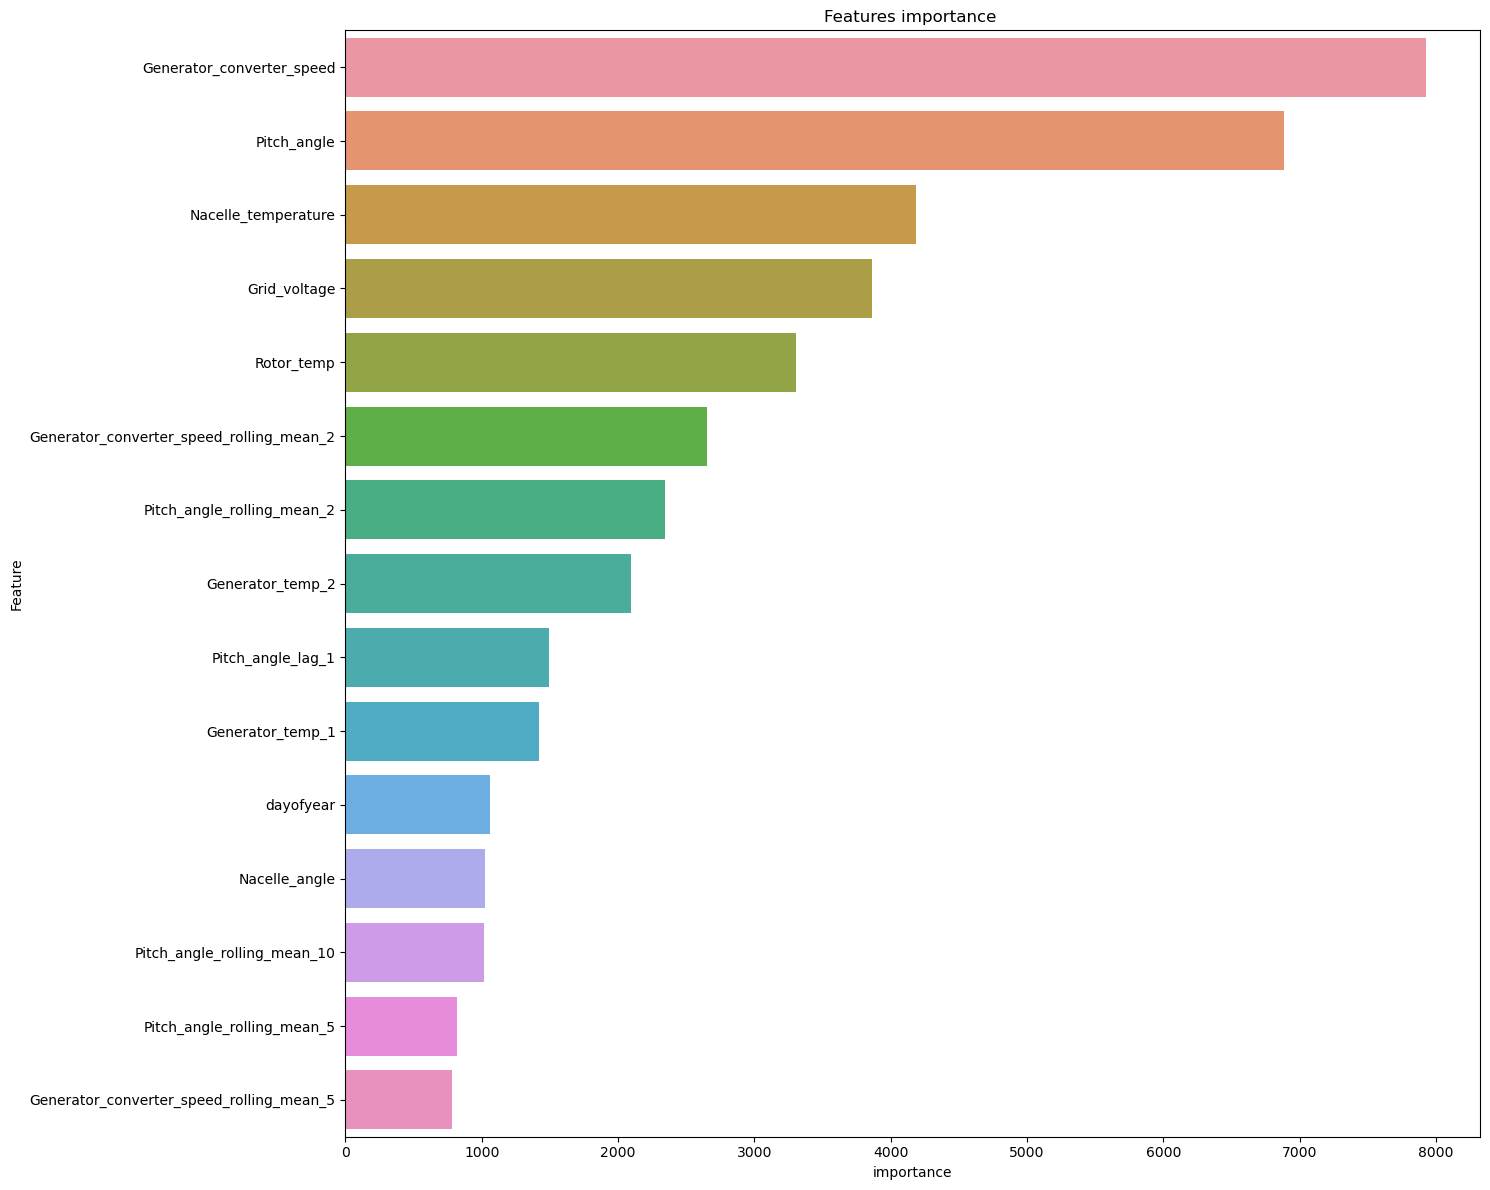

 MAE Val score = 246.9122
 MEDIAN AE Val score = 106.9658
 r2_score Val score =  0.1320
TRAINING IN FOLD :  1
[1]	valid_0's mape: 0.890911
Training until validation scores don't improve for 200 rounds
[2]	valid_0's mape: 0.885107
[3]	valid_0's mape: 0.878894
[4]	valid_0's mape: 0.872947
[5]	valid_0's mape: 0.867358
[6]	valid_0's mape: 0.861291
[7]	valid_0's mape: 0.855518
[8]	valid_0's mape: 0.84987
[9]	valid_0's mape: 0.844393
[10]	valid_0's mape: 0.839026
[11]	valid_0's mape: 0.833675
[12]	valid_0's mape: 0.828389
[13]	valid_0's mape: 0.823275
[14]	valid_0's mape: 0.818142
[15]	valid_0's mape: 0.812975
[16]	valid_0's mape: 0.808053
[17]	valid_0's mape: 0.802975
[18]	valid_0's mape: 0.797628
[19]	valid_0's mape: 0.792623
[20]	valid_0's mape: 0.787768
[21]	valid_0's mape: 0.782802
[22]	valid_0's mape: 0.778078
[23]	valid_0's mape: 0.773543
[24]	valid_0's mape: 0.768882
[25]	valid_0's mape: 0.764308
[26]	valid_0's mape: 0.759697
[27]	valid_0's mape: 0.755344
[28]	valid_0's mape: 0.75098

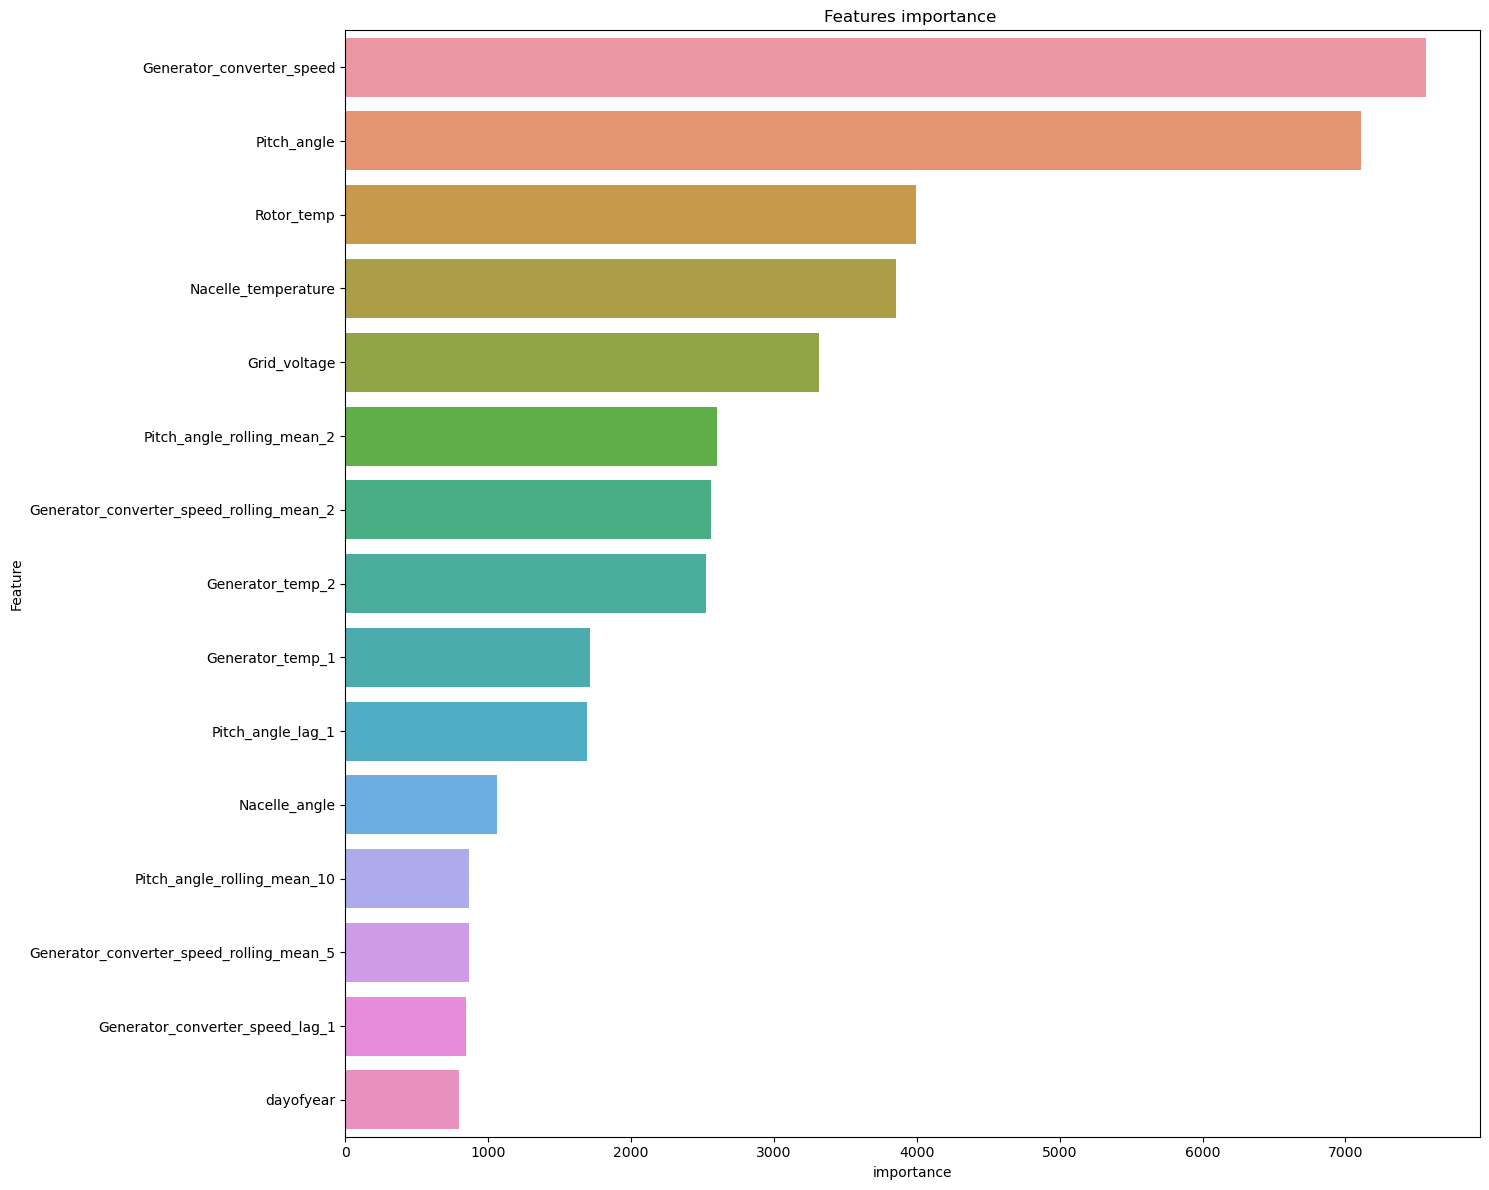

 MAE Val score = 233.3381
 MEDIAN AE Val score = 87.7960
 r2_score Val score =  0.0690
TRAINING IN FOLD :  2
[1]	valid_0's mape: 0.943172
Training until validation scores don't improve for 200 rounds
[2]	valid_0's mape: 0.936698
[3]	valid_0's mape: 0.930502
[4]	valid_0's mape: 0.924421
[5]	valid_0's mape: 0.918675
[6]	valid_0's mape: 0.912628
[7]	valid_0's mape: 0.906769
[8]	valid_0's mape: 0.90082
[9]	valid_0's mape: 0.895031
[10]	valid_0's mape: 0.889101
[11]	valid_0's mape: 0.883395
[12]	valid_0's mape: 0.877638
[13]	valid_0's mape: 0.872199
[14]	valid_0's mape: 0.866367
[15]	valid_0's mape: 0.8608
[16]	valid_0's mape: 0.855398
[17]	valid_0's mape: 0.85005
[18]	valid_0's mape: 0.844405
[19]	valid_0's mape: 0.83894
[20]	valid_0's mape: 0.833731
[21]	valid_0's mape: 0.828437
[22]	valid_0's mape: 0.823266
[23]	valid_0's mape: 0.817989
[24]	valid_0's mape: 0.813049
[25]	valid_0's mape: 0.807922
[26]	valid_0's mape: 0.80304
[27]	valid_0's mape: 0.797759
[28]	valid_0's mape: 0.792729
[29]

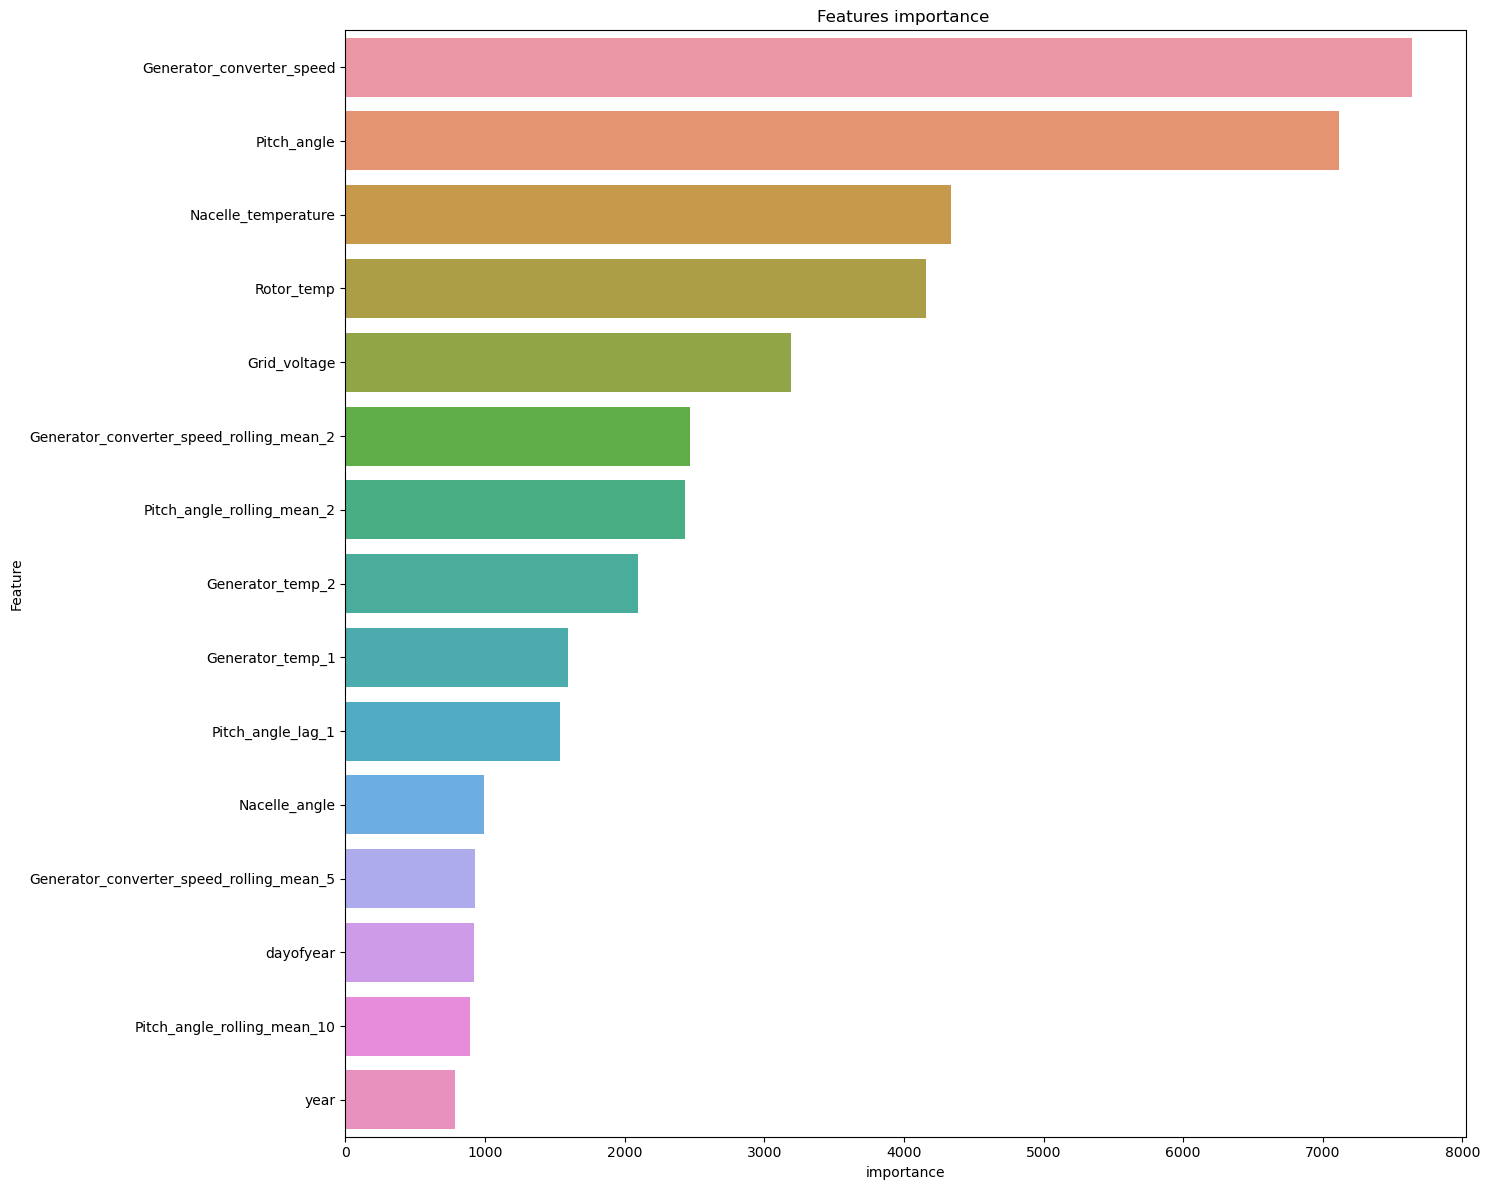

 MAE Val score = 211.0843
 MEDIAN AE Val score = 85.0742
 r2_score Val score =  0.2325
TRAINING IN FOLD :  3
[1]	valid_0's mape: 0.861911
Training until validation scores don't improve for 200 rounds
[2]	valid_0's mape: 0.855867
[3]	valid_0's mape: 0.849861
[4]	valid_0's mape: 0.843886
[5]	valid_0's mape: 0.838363
[6]	valid_0's mape: 0.832495
[7]	valid_0's mape: 0.826771
[8]	valid_0's mape: 0.82096
[9]	valid_0's mape: 0.815249
[10]	valid_0's mape: 0.809424
[11]	valid_0's mape: 0.803958
[12]	valid_0's mape: 0.798516
[13]	valid_0's mape: 0.793301
[14]	valid_0's mape: 0.787685
[15]	valid_0's mape: 0.782372
[16]	valid_0's mape: 0.777176
[17]	valid_0's mape: 0.771896
[18]	valid_0's mape: 0.766819
[19]	valid_0's mape: 0.761712
[20]	valid_0's mape: 0.756898
[21]	valid_0's mape: 0.751879
[22]	valid_0's mape: 0.747009
[23]	valid_0's mape: 0.742066
[24]	valid_0's mape: 0.737388
[25]	valid_0's mape: 0.732507
[26]	valid_0's mape: 0.727874
[27]	valid_0's mape: 0.723083
[28]	valid_0's mape: 0.718404

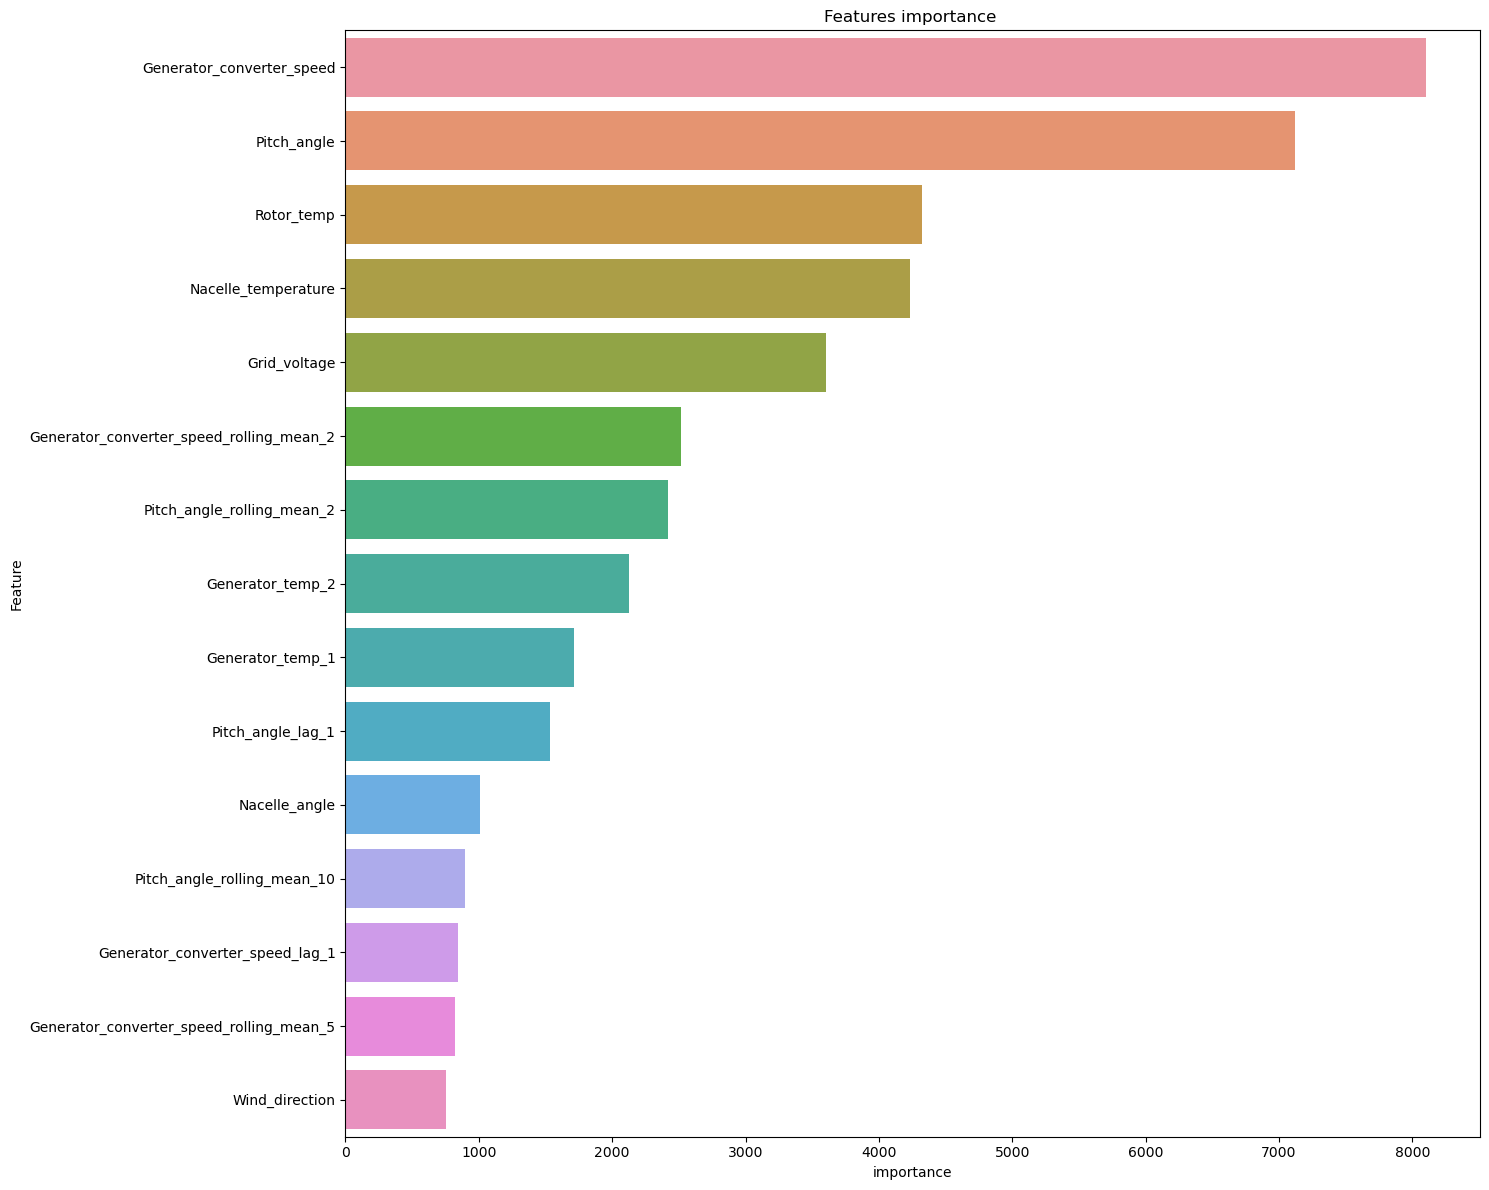

 MAE Val score = 179.3811
 MEDIAN AE Val score = 46.8839
 r2_score Val score =  0.3529
TRAINING IN FOLD :  4
[1]	valid_0's mape: 0.897185
Training until validation scores don't improve for 200 rounds
[2]	valid_0's mape: 0.889527
[3]	valid_0's mape: 0.882705
[4]	valid_0's mape: 0.876001
[5]	valid_0's mape: 0.869532
[6]	valid_0's mape: 0.863193
[7]	valid_0's mape: 0.856893
[8]	valid_0's mape: 0.850662
[9]	valid_0's mape: 0.844548
[10]	valid_0's mape: 0.83808
[11]	valid_0's mape: 0.831882
[12]	valid_0's mape: 0.825789
[13]	valid_0's mape: 0.819832
[14]	valid_0's mape: 0.813819
[15]	valid_0's mape: 0.807976
[16]	valid_0's mape: 0.803223
[17]	valid_0's mape: 0.796675
[18]	valid_0's mape: 0.791416
[19]	valid_0's mape: 0.785056
[20]	valid_0's mape: 0.778878
[21]	valid_0's mape: 0.773427
[22]	valid_0's mape: 0.767081
[23]	valid_0's mape: 0.760472
[24]	valid_0's mape: 0.754556
[25]	valid_0's mape: 0.748674
[26]	valid_0's mape: 0.742975
[27]	valid_0's mape: 0.736635
[28]	valid_0's mape: 0.73155


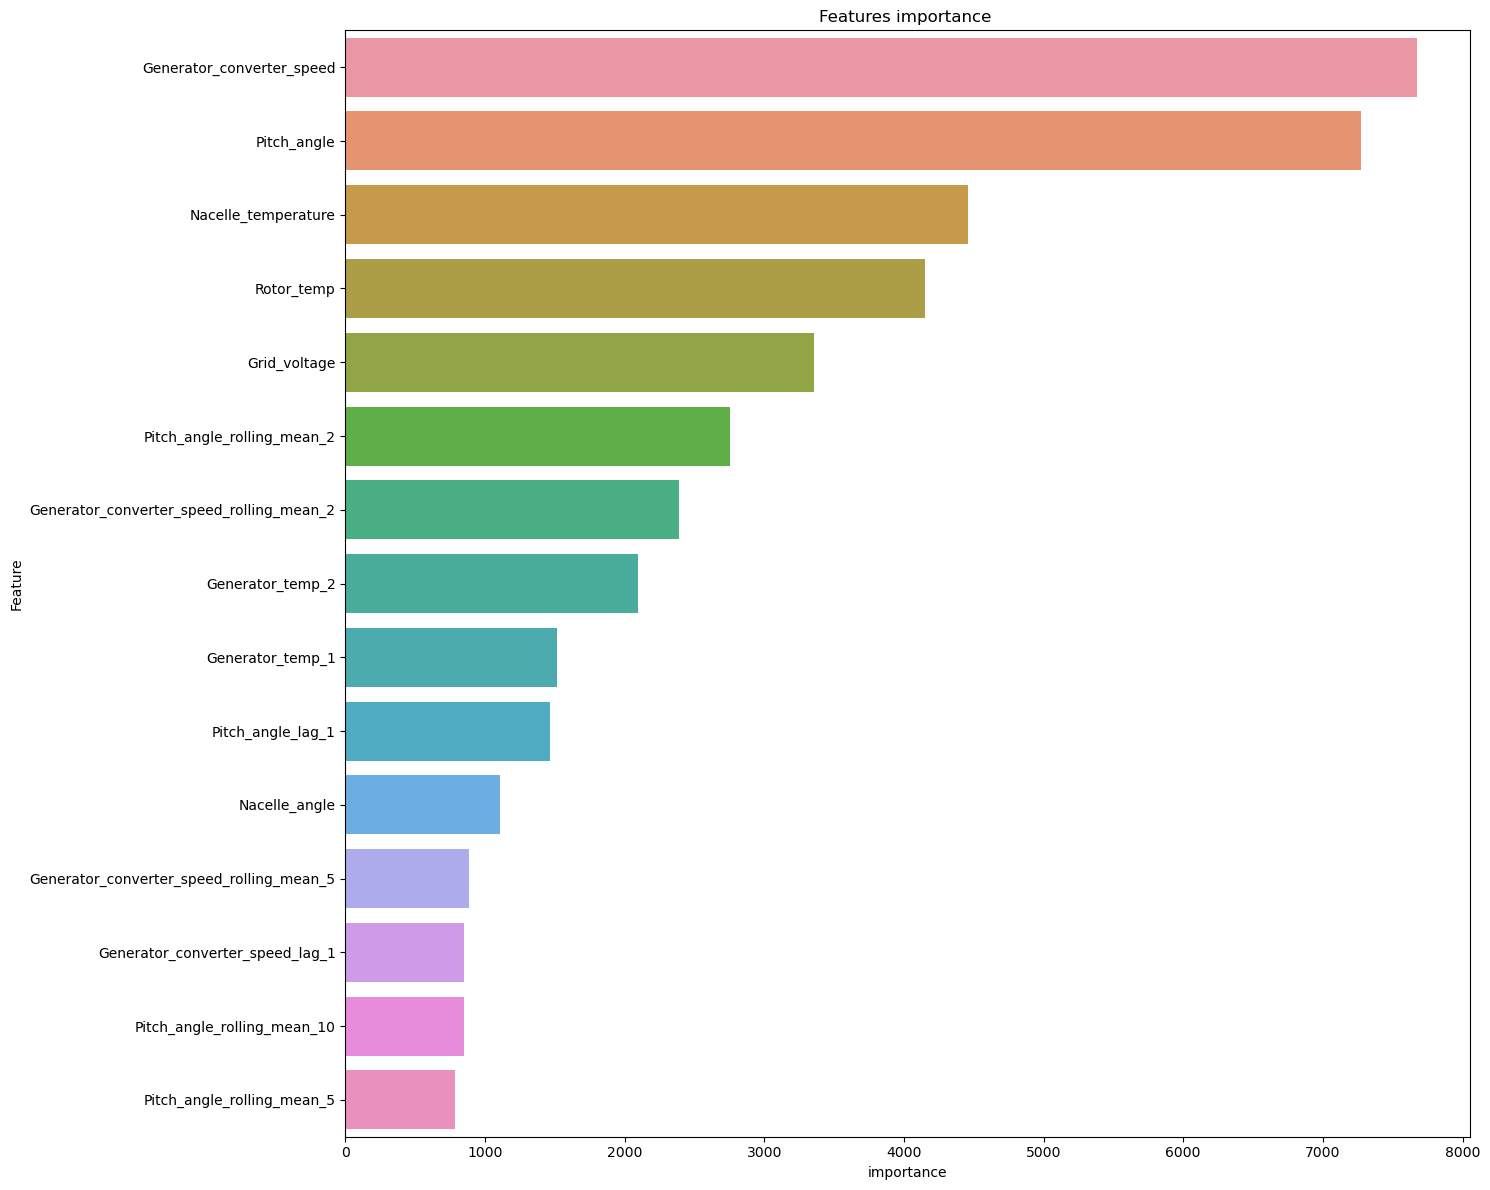

 MAE Val score = 220.0904
 MEDIAN AE Val score = 73.5389
 r2_score Val score =  0.2124


In [24]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.model_selection import KFold

# Define the number of folds
num_folds = 5
kf = KFold(n_splits=num_folds)


valid_scores = []
models = []
y_preds = []

for fold, (train_index, valid_index) in enumerate(kf.split(df_train)):
    print("TRAINING IN FOLD : ", fold)
    X_train, y_train = df_train.iloc[train_index].drop(columns="Power"), df_train.Power[train_index]
    X_valid, y_valid = df_train.iloc[valid_index].drop(columns="Power"), df_train.Power[valid_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    model = lgb.train(params, train_set=lgb_train, valid_sets=lgb_eval,
                      early_stopping_rounds=200)

    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
    valid_score = mean_absolute_error(y_valid, y_pred)
    valid_scores.append(valid_score)
    models.append(model)
    y_preds.append(model.predict(df_test, num_iteration=model.best_iteration))

    lgbm_features_importance(model,df_test.columns)

    print(f' MAE Val score = {valid_score:.4f}')
    print(f' MEDIAN AE Val score = {median_absolute_error(y_valid, y_pred):.4f}')
    print(f' r2_score Val score =  {r2_score(y_valid, y_pred):.4f}')

In [25]:
print(f' valid_scores = {np.median(valid_scores)}')

 valid_scores = 220.09043064202473


In [26]:
_y_pred = []
for model in models:
    _y_pred.append(model.predict(df_test, num_iteration=model.best_iteration))
_y_pred = np.array(_y_pred)

In [27]:
y_pred = _y_pred.mean(axis=0)

In [28]:
y_pred = pd.DataFrame(y_pred, columns=["y_pred"])
y_pred.to_csv("y_pred.csv", index=False)

## MODELS TEST:

In [29]:
from sklearn.model_selection import train_test_split
X_train , X_test, y_train, y_test = train_test_split(df_train, df_train[['Power']], train_size=0.7, random_state=0)

In [30]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.svm import NuSVR, SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import pandas as pd

models = {
    'CatBoost': CatBoostRegressor(random_state=42, verbose=False),
    'LGBM': LGBMRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    #'NuSVR': NuSVR(),
    #'SVR': SVR(),
    'MLP': MLPRegressor(random_state=42)
}

def test_regression_models(models, X_train, X_test, y_train, y_test):

    _models_ = []
    results = {'Model': [], 'R2': [], 'MSE': [], 'RMSE': []}

    for name, model in tqdm(models.items()):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        results['Model'].append(name)
        results['R2'].append(r2)
        results['MSE'].append(mse)
        results['RMSE'].append(rmse)
        _models_.append({name:model})

    return pd.DataFrame(results), _models_


In [31]:
results, _models_ = test_regression_models(X_train, X_test, y_train, y_test)

  0%|          | 0/4 [00:00<?, ?it/s]

In [32]:
results

,Model,R2,MSE,RMSE
0,CatBoost,0.999862,24.058419,4.904938
1,LGBM,0.999887,19.696173,4.438037
2,XGBoost,0.999997,0.588924,0.767414
3,MLP,0.999999,0.183127,0.427934


In [33]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define base models
models = [
    ('catboost', CatBoostRegressor(random_state=42)),
    ('lgbm', LGBMRegressor(random_state=42)),
    ('xgboost', XGBRegressor(random_state=42)),
    #('nusvr', NuSVR()),
    #('svr', SVR()),
    ('mlp', MLPRegressor(random_state=42))
]

# Define meta model
meta_model = LinearRegression()

# Define stacking regressor
stacking_regressor = StackingRegressor(
    estimators=models,
    final_estimator=meta_model,
    cv=5
)

# Train stacking regressor
stacking_regressor.fit(X_train, y_train)

# Make predictions
y_pred = stacking_regressor.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')


Learning rate set to 0.082832
0:	learn: 383.9810462	total: 48.7ms	remaining: 48.7s
1:	learn: 353.9983038	total: 90.9ms	remaining: 45.4s
2:	learn: 326.2864116	total: 133ms	remaining: 44.3s
3:	learn: 300.4604431	total: 172ms	remaining: 42.9s
4:	learn: 276.8512136	total: 216ms	remaining: 43.1s
5:	learn: 255.0586739	total: 257ms	remaining: 42.6s
6:	learn: 235.1498399	total: 298ms	remaining: 42.3s
7:	learn: 216.6442686	total: 337ms	remaining: 41.8s
8:	learn: 199.4052628	total: 375ms	remaining: 41.3s
9:	learn: 183.8391800	total: 415ms	remaining: 41.1s
10:	learn: 169.6402122	total: 456ms	remaining: 41s
11:	learn: 156.3471015	total: 494ms	remaining: 40.7s
12:	learn: 144.3432014	total: 534ms	remaining: 40.5s
13:	learn: 133.1715365	total: 572ms	remaining: 40.3s
14:	learn: 122.9050161	total: 612ms	remaining: 40.2s
15:	learn: 113.4105398	total: 651ms	remaining: 40.1s
16:	learn: 104.6202536	total: 695ms	remaining: 40.2s
17:	learn: 96.6443035	total: 732ms	remaining: 39.9s
18:	learn: 89.3208579	total